In [1]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, accuracy_score


In [2]:
conn = sql.connect('db.sqlite')
cards = pd.read_sql_query("SELECT * FROM cards", conn)

customers = pd.read_sql_query("SELECT * FROM customers", conn)

transactions = pd.read_sql_query("SELECT * FROM transactions", conn)

CBtransactions = pd.read_excel("Processing Report.xlsx")

print(transactions.info(),cards.info(),customers.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34887 entries, 0 to 34886
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          34887 non-null  int64 
 1   created_at  34887 non-null  object
 2   succes      34887 non-null  int64 
 3   amount      34887 non-null  int64 
 4   currency    34887 non-null  object
 5   acq_tid     34887 non-null  object
 6   card_id     34887 non-null  int64 
 7   cb          34887 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 2.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9997 entries, 0 to 9996
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           9997 non-null   int64 
 1   created_at   9997 non-null   object
 2   bin          9997 non-null   object
 3   last_4       9997 non-null   object
 4   exp_year     9997 non-null   int64 
 5   exp_month    9997 non-null   int64 
 6   bra

In [3]:
CBARN = []
for row in CBtransactions["ARN"]:
    CBARN.append(row)

mask = transactions['acq_tid'].isin(CBARN)
CBtransactionsMatched = transactions[mask]


TransactionsBeforeNewVal = CBtransactionsMatched["cb"]
TransactionsAfterNewVal = TransactionsBeforeNewVal.replace([0],"1")
CBtransactionsMatched["cb"] = 1
CBtransactionsMatched

transactions.update(CBtransactionsMatched)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [4]:
# CardsToAnalysis = cards[["id","brand"]]
CardsToAnalysis = cards[["id","brand","bin_country"]]
transactionsEXT = pd.merge(transactions, CardsToAnalysis, left_on='card_id', right_on ="id", how='left')
transactionsEXT
# transactions
# transactionsEXT.to_excel("nwm.xlsx") 
  



,id_x,created_at,succes,amount,currency,acq_tid,card_id,cb,id_y,brand,bin_country
0,1.507277e+09,2017-10-06 09:55:19,1.0,1300.0,USD,2DD77FW7-1507276519-100375145-6UDOLBNLXD,1.492867e+09,0.0,1492866731,mastercard,CZ
1,1.512263e+09,2017-12-03 01:57:17,1.0,400.0,USD,2DD77FW7-1512262637-100375145-5JEOCILQ7T,1.492867e+09,0.0,1492866731,mastercard,CZ
2,1.509745e+09,2017-11-03 22:39:17,0.0,3100.0,USD,2DD77FW7-1509745157-100375982-BTT12YQNUZ,1.492867e+09,0.0,1492866731,mastercard,CZ
3,1.507922e+09,2017-10-13 21:08:44,1.0,1300.0,EUR,2DD77FW7-1507921724-100375856-TRGTYMVYHO,1.508145e+09,0.0,1508145460,visa,VE
4,1.514278e+09,2017-12-26 09:39:19,0.0,900.0,USD,2DD77FW7-1514277559-100632165-2IGY9D935C,1.508145e+09,0.0,1508145460,visa,VE
...,...,...,...,...,...,...,...,...,...,...,...
34882,1.509344e+09,2017-10-30 07:16:02,0.0,1100.0,EUR,2DD77FW7-1509344162-100375982-MLL5EI46VB,1.486963e+09,0.0,1486963470,visa,LU
34883,1.508248e+09,2017-10-17 15:42:10,1.0,500.0,USD,2DD77FW7-1508247730-100375982-EC6TWNFBKG,1.486963e+09,0.0,1486963470,visa,LU
34884,1.511906e+09,2017-11-28 22:57:42,1.0,2000.0,EUR,2DD77FW7-1511906262-100632165-L910QUP8H3,1.486963e+09,0.0,1486963470,visa,LU
34885,1.507233e+09,2017-10-05 21:42:41,1.0,1900.0,USD,2DD77FW7-1507232561-100375856-XDYEYEG4RD,1.486963e+09,0.0,1486963470,visa,LU


In [5]:
# Data = transactionsEXT[["amount","currency","brand"]]
Data = transactionsEXT[["amount","currency","brand","bin_country"]]
y = transactionsEXT["cb"]

encoder = OneHotEncoder(sparse=False)
# ToEncode = Data[["currency","brand"]]
ToEncode = Data[["currency","brand","bin_country"]]
DataEncoded = encoder.fit_transform(ToEncode)

colnames = []
for cat in encoder.categories_[0]:
    colnames.append(f'currency_{cat}')
for cat in encoder.categories_[1]:
    colnames.append(f'brand_{cat}')
for cat in encoder.categories_[2]:
    colnames.append(f'bin_country_{cat}')


EncodedX = pd.DataFrame(DataEncoded, columns= colnames)
EncodedX["amount"] = transactions["amount"]
X = EncodedX
X




,currency_EUR,currency_USD,brand_mastercard,brand_visa,bin_country_AE,bin_country_AR,bin_country_AU,bin_country_BE,bin_country_BS,bin_country_CA,...,bin_country_RS,bin_country_RU,bin_country_SA,bin_country_SE,bin_country_TH,bin_country_TR,bin_country_TZ,bin_country_US,bin_country_VE,amount
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1300.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,400.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3100.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1300.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34882,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1100.0
34883,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,500.0
34884,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000.0
34885,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1900.0


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


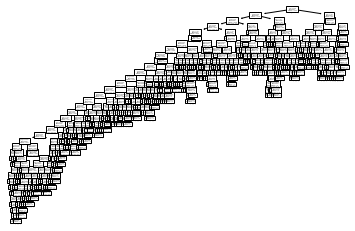

In [7]:
Tree = DecisionTreeClassifier()
Tree.fit(X_train, y_train)
plot_tree(Tree)
plt.show()

In [8]:
TreePred = Tree.predict(X_test)
accuracy_score(y_test, TreePred)

       


0.9935511607910577

In [9]:
params={'criterion':['gini', 'entropy'],
       'max_depth':[1, 2, 3, 4,5,6]}
grid = GridSearchCV(estimator=Tree, 
                    param_grid=params, 
                    verbose=10, 
                    scoring='accuracy',
                   cv=10)
grid.fit(X_train, y_train)
BestGrid = grid.best_estimator_
BestGrid.fit(X_train, y_train)
BestGrid.feature_importances_

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] criterion=gini, max_depth=1 .....................................
[CV] ......... criterion=gini, max_depth=1, score=0.995, total=   0.0s
[CV] criterion=gini, max_depth=1 .....................................
[CV] ......... criterion=gini, max_depth=1, score=0.994, total=   0.0s
[CV] criterion=gini, max_depth=1 .....................................
[CV] ......... criterion=gini, max_depth=1, score=0.994, total=   0.0s
[CV] criterion=gini, max_depth=1 .....................................
[CV] ......... criterion=gini, max_depth=1, score=0.994, total=   0.0s
[CV] criterion=gini, max_depth=1 .....................................
[CV] ......... criterion=gini, max_depth=1, score=0.994, total=   0.0s
[CV] criterion=gini, max_depth=1 .....................................
[CV] ......... criterion=gini, max_depth=1, score=0.994, total=   0.0s
[CV] criterion=gini, max_depth=1 .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s


[CV] ......... criterion=gini, max_depth=1, score=0.994, total=   0.0s
[CV] criterion=gini, max_depth=1 .....................................
[CV] ......... criterion=gini, max_depth=1, score=0.994, total=   0.0s
[CV] criterion=gini, max_depth=1 .....................................
[CV] ......... criterion=gini, max_depth=1, score=0.994, total=   0.0s
[CV] criterion=gini, max_depth=1 .....................................
[CV] ......... criterion=gini, max_depth=1, score=0.995, total=   0.0s
[CV] criterion=gini, max_depth=2 .....................................
[CV] ......... criterion=gini, max_depth=2, score=0.995, total=   0.0s
[CV] criterion=gini, max_depth=2 .....................................
[CV] ......... criterion=gini, max_depth=2, score=0.994, total=   0.0s
[CV] criterion=gini, max_depth=2 .....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.2s remaining:    0.0s


[CV] ......... criterion=gini, max_depth=2, score=0.994, total=   0.1s
[CV] criterion=gini, max_depth=2 .....................................
[CV] ......... criterion=gini, max_depth=2, score=0.994, total=   0.0s
[CV] criterion=gini, max_depth=2 .....................................
[CV] ......... criterion=gini, max_depth=2, score=0.994, total=   0.0s
[CV] criterion=gini, max_depth=2 .....................................
[CV] ......... criterion=gini, max_depth=2, score=0.994, total=   0.0s
[CV] criterion=gini, max_depth=2 .....................................
[CV] ......... criterion=gini, max_depth=2, score=0.994, total=   0.0s
[CV] criterion=gini, max_depth=2 .....................................
[CV] ......... criterion=gini, max_depth=2, score=0.994, total=   0.0s
[CV] criterion=gini, max_depth=2 .....................................
[CV] ......... criterion=gini, max_depth=2, score=0.994, total=   0.0s
[CV] criterion=gini, max_depth=2 .....................................
[CV] .

[CV] ...... criterion=entropy, max_depth=2, score=0.994, total=   0.0s
[CV] criterion=entropy, max_depth=2 ..................................
[CV] ...... criterion=entropy, max_depth=2, score=0.994, total=   0.0s
[CV] criterion=entropy, max_depth=2 ..................................
[CV] ...... criterion=entropy, max_depth=2, score=0.994, total=   0.0s
[CV] criterion=entropy, max_depth=2 ..................................
[CV] ...... criterion=entropy, max_depth=2, score=0.994, total=   0.0s
[CV] criterion=entropy, max_depth=2 ..................................
[CV] ...... criterion=entropy, max_depth=2, score=0.995, total=   0.0s
[CV] criterion=entropy, max_depth=3 ..................................
[CV] ...... criterion=entropy, max_depth=3, score=0.995, total=   0.0s
[CV] criterion=entropy, max_depth=3 ..................................
[CV] ...... criterion=entropy, max_depth=3, score=0.994, total=   0.0s
[CV] criterion=entropy, max_depth=3 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    5.6s finished


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0.])

In [38]:
Forest = RandomForestClassifier()
Forest.fit(X_train, y_train)
ForestPred=Forest.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, ForestPred))

Forest.feature_importances_

# total = np.sum(Forest.feature_importances_)
# total



Accuracy: 0.9935511607910577


array([1.89942781e-02, 2.12619870e-02, 1.48533298e-02, 1.69034086e-02,
       6.68293798e-04, 7.19271496e-04, 1.74473706e-03, 6.09745370e-04,
       9.38865113e-04, 6.82941152e-04, 1.47845121e-03, 1.02996047e-03,
       4.42801934e-03, 1.28903572e-03, 8.90664803e-05, 1.10089174e-03,
       2.11028275e-04, 1.90051019e-04, 6.18172299e-03, 1.21409346e-04,
       1.53199962e-03, 1.59244649e-04, 6.98130311e-04, 2.14700955e-03,
       7.49850281e-04, 1.62994120e-03, 8.77932941e-04, 1.68175199e-04,
       1.54840319e-04, 1.99479512e-04, 1.10656080e-03, 2.32824515e-03,
       1.56996905e-03, 1.77332197e-04, 2.10246675e-04, 1.37185437e-03,
       1.45440367e-03, 3.73661039e-03, 1.34540163e-04, 1.16231192e-04,
       2.27171923e-03, 2.89211317e-03, 4.90913713e-04, 1.63561613e-03,
       1.37051405e-03, 8.92307395e-03, 2.13213344e-03, 7.33151782e-04,
       2.95091226e-02, 1.13231282e-02, 3.19680328e-03, 4.28810276e-02,
       1.16150641e-03, 7.77460085e-01])

In [13]:
# Model Bayesa
Bayes = GaussianNB()
Bayes.fit(X_train, y_train)
Bayes.class_prior_
Bayes_acc = Bayes.score(X_test,y_test)
Bayes_acc



0.7469188879335052

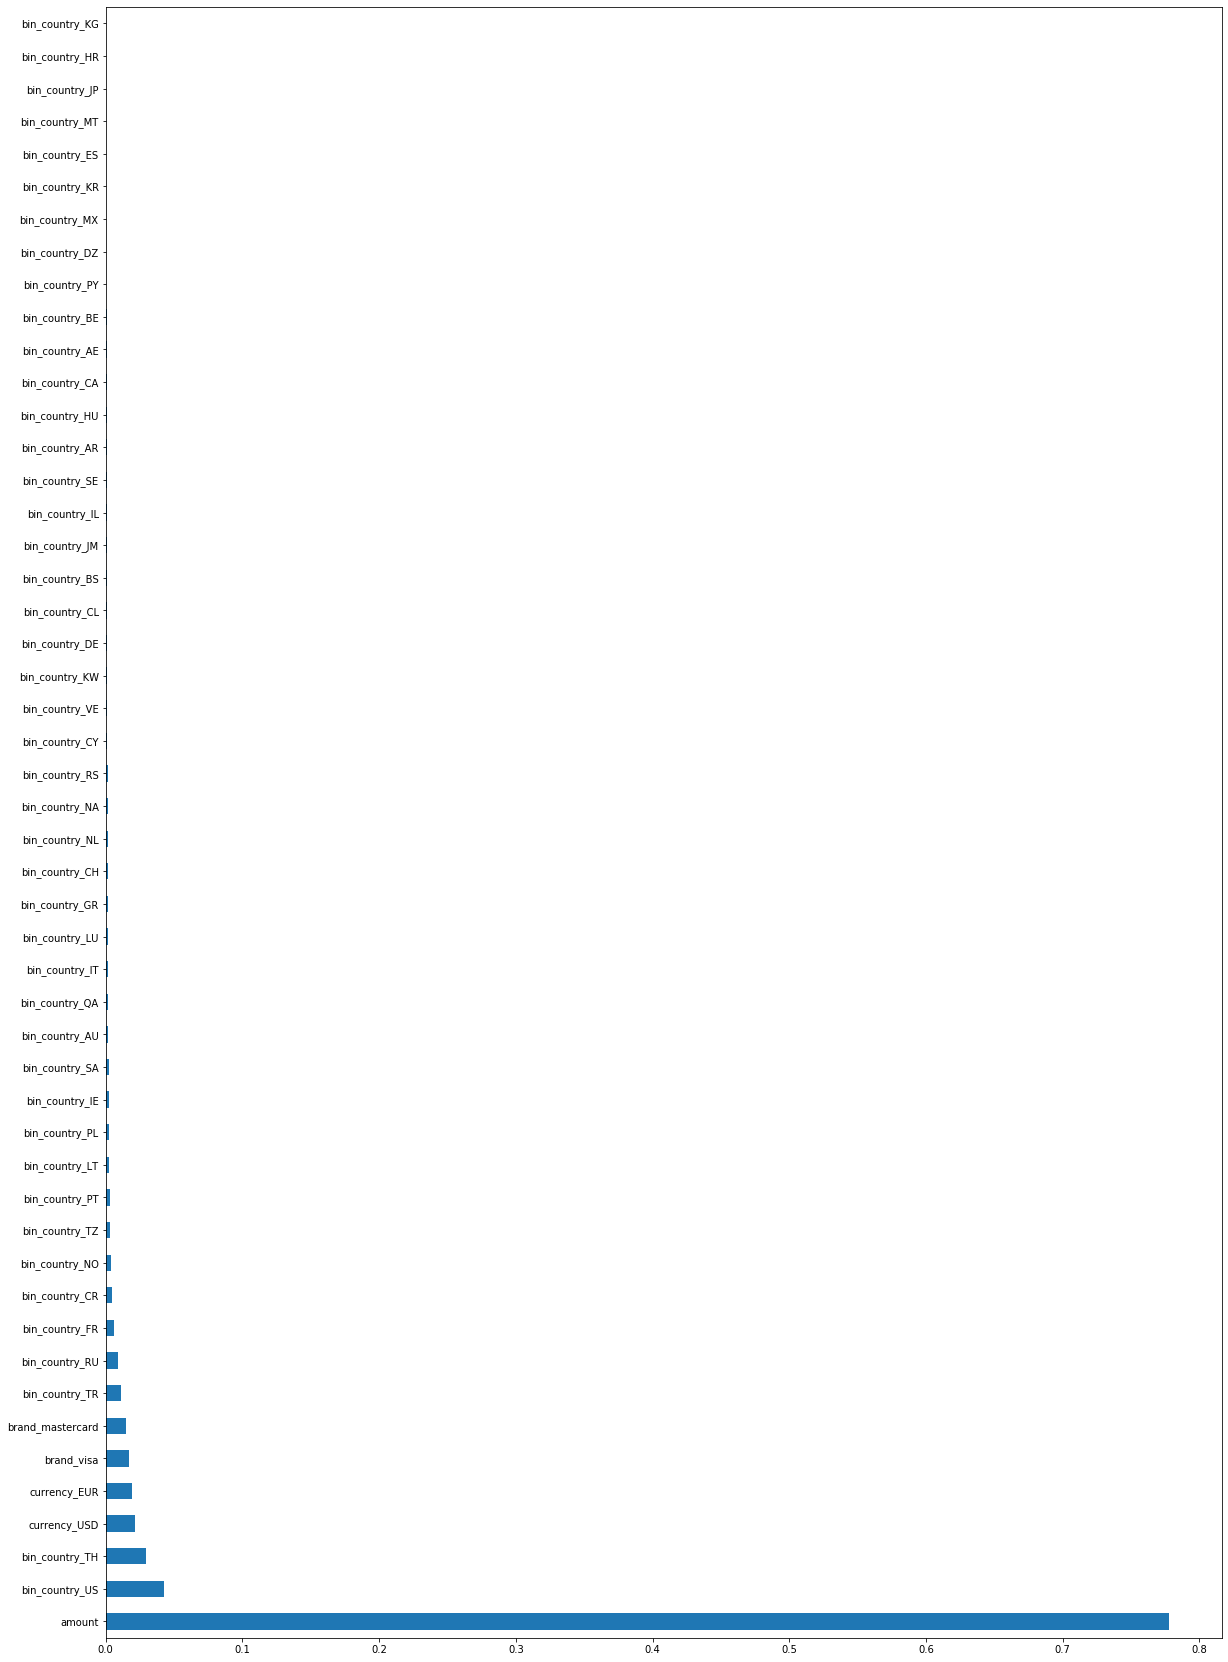

In [48]:
feat_importances = pd.Series(Forest.feature_importances_, index=X.columns)
feat_importances.nlargest(50).plot(kind='barh')

In [43]:
# XGBoost
XGB = XGBClassifier()
XGB.fit(X_train, y_train)
# make predictions for test data
XGBpred = XGB.predict(X_test)
predictions = [round(value) for value in XGBpred]
accuracy = accuracy_score(y_test, predictions)
accuracy
# XGB.feature_importances_

0.9949842361708225

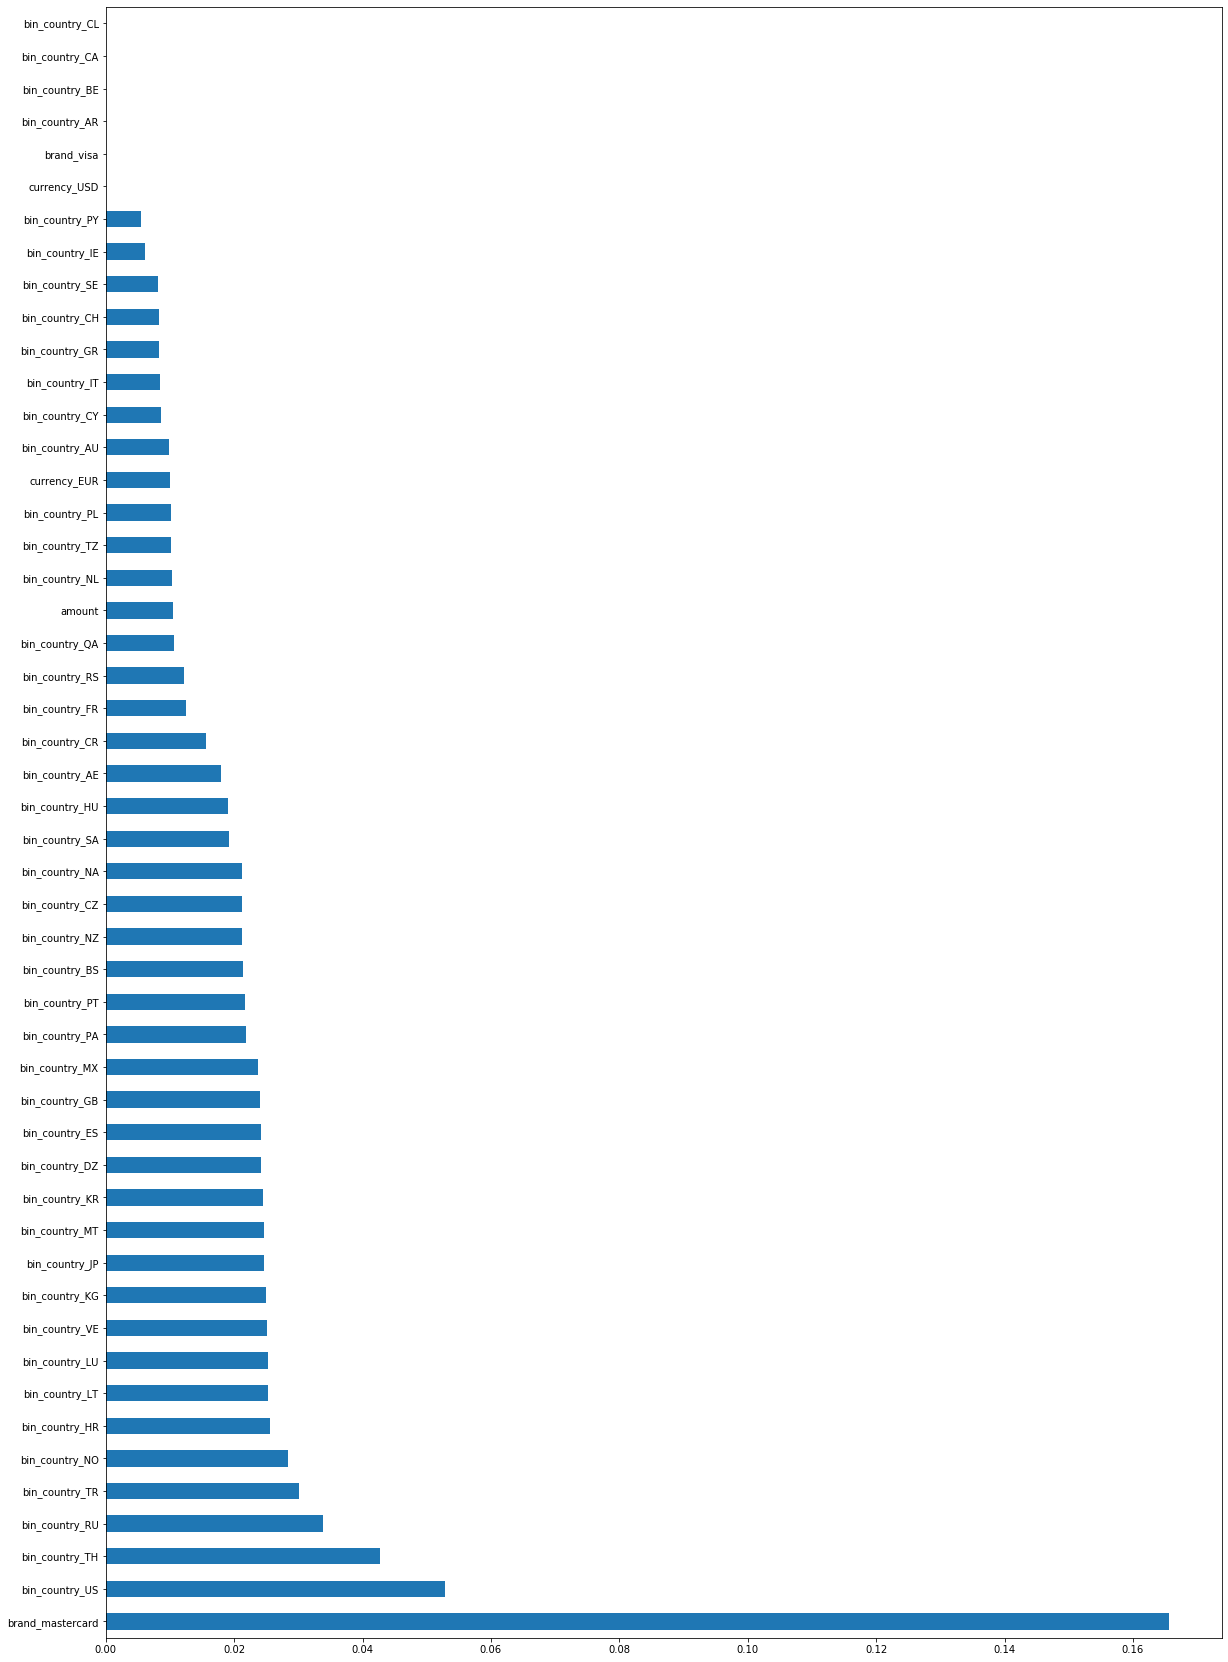

In [47]:
from numpy import loadtxt
from matplotlib import pyplot
plt.rcParams["figure.figsize"] = (20,30)
feat_importances = pd.Series(XGB.feature_importances_, index=X.columns)
feat_importances.nlargest(50).plot(kind='barh')
# feature_imp = pd.Series(XGB.feature_importances_).sort_values(ascending=False)
# feature_imp

# ImportantCols = feature_imp
# ImportantCols

# 54 kolumny

{'importances_mean': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         2.86615076e-05,  2.86615076e-05,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  8.59845228e-05,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  5.73230152e-05,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -2.86615076e-05,  2.86615076e-05,  0.00000000e+00,  8.59845228e-05,
         0.00000000e+00,  5.73230152e-05,  5.73230152e-05,  0.00000000e+00,
         2.86615076e-05,  8.59845228e-05,  2.86615076e-05,  8.598452

In [32]:
# from sklearn.linear_model import LogisticRegression
# model = LogisticRegression()
# model.fit(X_train, y_train)
# modelpred = model.predict(X_test)
# wynik = model.score(X_test,y_test)
# wynik
import eli5
from eli5.sklearn import PermutationImportance
feature_names = X_test.columns.tolist()
eli5.show_weights(perm_importance, top=None, feature_names=feature_names)

ModuleNotFoundError: No module named 'eli5'

In [18]:
from matplotlib import pyplot
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

NameError: name 'model' is not defined

In [49]:
0.9949842361708225>0.9935511607910577

True